In [1]:
import pandas as pd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [8]:
year = "20"
donors_csv = f"../output/donors_agg_pred_lastname_trunc.csv"
unique_csv = f"../output/top_donors_unique.csv"
manual_csv = f"C:/Users/karnav/Downloads/Donors Filtered - top_donors_unique(1).csv"

In [9]:
donors = pd.read_csv(donors_csv)
donors

,contrib_id,name_new,orgname,realcode,gender,occupation,city,state,total_donated,donation_count,avg_donation,med_donation,combined_ratio,indian,cycle,sector
0,1,ampac ampac,[24I Contribution],Z9500,,NaN,WASHINGTON,DC,379351224.0,30966,12250.572370,1000.0,0.000000,False,2000,Party
1,,,[Candidate Contribution],Y4000,,NaN,NaN,,144446528.0,19266,7497.484065,300.0,0.000000,False,2000,Unknown
2,a0000305213,steve forbes,[Candidate Contribution],Z9000,M,NaN,NaN,,7050000.0,11,640909.090909,750000.0,0.016339,False,2000,Party
3,U00000003381,s daniel abraham,Slim-Fast Foods,H4600,M,NaN,WEST PALM BEACH,FL,1615500.0,53,30481.132075,1000.0,0.248928,False,2000,Health
4,U00000002531,bernard l schwartz,Loral Space & Communications,C4400,M,NaN,NEW YORK,NY,1355000.0,44,30795.454545,20000.0,0.000000,False,2000,Tech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18155765,s0009731398,yen tan,NaN,Y2000,F,BEST EFFORT,ROCHESTER,NY,1.0,1,1.000000,1.0,0.089469,False,2022,Unknown
18155766,r0003168080,janie terwilliger,Kingsway Christian School,Y4000,F,BAND AND DRAMA TEACHER,WOOSTER,OH,1.0,1,1.000000,1.0,0.004902,False,2022,Unknown
18155767,r0022968069,lindsey chapman,[24T Contribution],Z9500,F,NaN,INTERVALE,NH,1.0,1,1.000000,1.0,0.000000,False,2022,Party
18155768,r0000859858,beth luvera,Key,Y4000,F,BANKING,UTICA,NY,1.0,1,1.000000,1.0,0.003314,False,2022,Finance


In [42]:
unique = pd.read_csv(unique_csv).sort_values(by=["total_donated", "contrib_id"], ascending=False).reset_index(drop=True)
unique["indian"] = unique["indian"].replace("FALSE", False).replace("FALSE ", False).replace("TRUE", True).replace("TRUE ", True)
unique

,contrib_id,name_new,orgname,realcode,gender,occupation,city,state,total_donated,donation_count,avg_donation,med_donation,combined_ratio,indian,cycle,sector
0,,raymond a,National Republican Senatorial Cmte,Z9600,,RETIRED,WASHINGTON,CA,1.649385e+09,115116,1.432803e+04,25.0,0.022464,False,2022,Party
1,U00000037041,michael r bloomberg,[Candidate Contribution],Z9000,M,FOUNDER,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,0.000000,False,2020,Party
2,U00000036521,tom steyer,[Candidate Contribution],Z9000,M,PRESIDENTIAL CANDIDATE,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,0.024310,False,2020,Party
3,1,ampac ampac,[24I Contribution],Z9500,,NaN,WASHINGTON,DC,3.793512e+08,30966,1.225057e+04,1000.0,0.000000,False,2000,Party
4,U00000003641,george soros,Soros Fund Management,F2700,M,EXECUTIVE,NEW YORK,NY,1.800173e+08,204,8.824376e+05,2900.0,0.041785,False,2022,Finance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60825,b0608603236,roy tanzman,"Wilentz, Goldman & Spitzer",K1000,M,NaN,KENDALL PARK,NJ,1.111000e+04,14,7.935714e+02,1000.0,0.311420,False,2002,Law
60826,d0000741676,bruce a finzen,"Robins, Kaplan et al",K1000,M,NaN,EAGAN,MN,1.110800e+04,15,7.405333e+02,1000.0,0.000000,False,2002,Law
60827,f1000688496,jeff more,Accord Group,K2000,M,NaN,WASHINGTON,DC,1.110000e+04,17,6.529412e+02,500.0,17.327435,False,2002,Law
60828,d1005360700,myra monfort,Retired,X1200,F,NaN,LONGBOAT KEY,FL,1.110000e+04,13,8.538462e+02,500.0,0.094099,False,2002,NaN


In [43]:
manual = pd.read_csv(manual_csv).sort_values(by=["total_donated", "contrib_id"], ascending=False).reset_index(drop=True)
manual["manual"] = manual["manual"].replace("FALSE", False).replace("FALSE ", False).replace("TRUE", True).replace("TRUE ", True)
manual["indian"] = manual["indian"].replace("FALSE", False).replace("FALSE ", False).replace("TRUE", True).replace("TRUE ", True)
manual

,contrib_id,name_new,orgname,indian,manual,realcode,gender,occupation,city,state,gpt_profile,total_donated,donation_count,avg_donation,med_donation,combined_ratio,cycle,sector
0,NaN,raymond a,National Republican Senatorial Cmte,False,False,Z9600,NaN,RETIRED,WASHINGTON,CA,NaN,1649385462,115116,1.432803e+04,25.0,0.022464,2022,Party
1,U00000037041,michael r bloomberg,[Candidate Contribution],False,False,Z9000,M,FOUNDER,NEW YORK,NY,NaN,1127731108,958,1.177172e+06,682.5,0.000000,2020,Party
2,U00000036521,tom steyer,[Candidate Contribution],False,False,Z9000,M,PRESIDENTIAL CANDIDATE,SAN FRANCISCO,CA,NaN,379478194,756,5.019553e+05,2800.0,0.024310,2020,Party
3,1,ampac ampac,[24I Contribution],False,False,Z9500,NaN,NaN,WASHINGTON,DC,NaN,379351224,30966,1.225057e+04,1000.0,0.000000,2000,Party
4,U00000003641,george soros,Soros Fund Management,False,False,F2700,M,EXECUTIVE,NEW YORK,NY,NaN,180017261,204,8.824376e+05,2900.0,0.041785,2022,Finance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60825,b0608603236,roy tanzman,"Wilentz, Goldman & Spitzer",False,False,K1000,M,NaN,KENDALL PARK,NJ,NaN,11110,14,7.935714e+02,1000.0,0.311420,2002,Law
60826,d0000741676,bruce a finzen,"Robins, Kaplan et al",False,False,K1000,M,NaN,EAGAN,MN,NaN,11108,15,7.405333e+02,1000.0,0.000000,2002,Law
60827,f1000688496,jeff more,Accord Group,False,False,K2000,M,NaN,WASHINGTON,DC,NaN,11100,17,6.529412e+02,500.0,17.327435,2002,Law
60828,d1005360700,myra monfort,Retired,False,False,X1200,F,NaN,LONGBOAT KEY,FL,NaN,11100,13,8.538462e+02,500.0,0.094099,2002,NaN


In [44]:
(unique["indian"] == manual["manual"]).value_counts()

True     60656
False      174
Name: count, dtype: int64

Accuracy: 0.9971
Precision: 0.8601
Recall: 0.8926
F1 Score: 0.8761


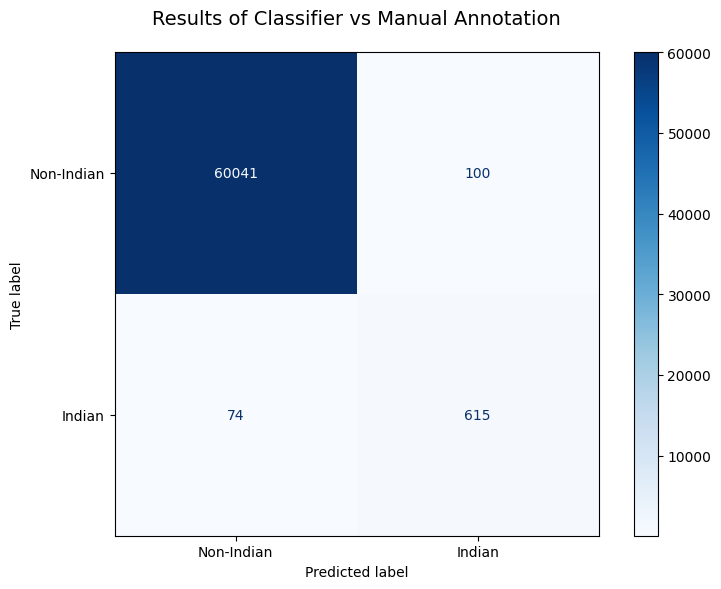

In [49]:
accuracy = accuracy_score(manual["manual"], unique["indian"])
precision = precision_score(manual["manual"], unique["indian"])
recall = recall_score(manual["manual"], unique["indian"])
f1 = f1_score(manual["manual"], unique["indian"])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(manual["manual"], unique["indian"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=['Non-Indian', 'Indian'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title("Results of Classifier vs Manual Annotation", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [46]:
unique[unique["indian"] != manual["manual"]][:20]

,contrib_id,name_new,orgname,realcode,gender,occupation,city,state,total_donated,donation_count,avg_donation,med_donation,combined_ratio,indian,cycle,sector
156,U0000003169,philip munger,Investor,F7000,M,INVESTOR,NEW YORK,NY,4881929.0,325,15021.320000,2700.0,0.180377,True,2016,Finance
604,U00000003781,amy joyce rao,Integrated Archive Systems,C5130,F,CEO,PALO ALTO,CA,1495229.0,567,2637.088183,200.0,8.309695,True,2016,Tech
804,U00000047351,reuben munger,Vision Ridge Partners,F2500,M,MANAGING PARTNER,BOULDER,CO,1192100.0,21,56766.666667,5800.0,0.343085,True,2022,Finance
1008,h3001549263,jean manas,Foros Group,F2300,F,FINANCE,NEW YORK,NY,1025600.0,11,93236.363636,2800.0,15.765398,True,2020,Finance
1375,p0004490796,eng goi,Opal Massage,G5000,N,MASSAGE THERAPIST,NEW YORK,NY,802700.0,33,24324.242424,10000.0,5.927968,True,2016,NaN
1535,c01802956181,jimmy rane,Great Southern Wood Preserving,B5200,M,CEO,ABBEVILLE,AL,732100.0,29,25244.827586,4700.0,19.858308,True,2020,Construction
1552,r0014803404,khalid alwan,Investor,F7000,M,SELF EMPLOYED,BEVERLY HILLS,CA,721838.0,125,5774.704000,3486.0,1.514358,True,2020,Finance
1670,m0001734575@,willa rao,Cai Corp,H4200,F,BUSINESS,EL MONTE,CA,675281.0,143,4722.244755,2700.0,8.309695,True,2016,Health
1984,j1001163824,griffith r iv harsh,Stanford University,H5100,M,NEUROSURGEON,ATHERTON,CA,580750.0,13,44673.076923,5000.0,12.626134,True,2012,Health
2624,h10011803191,reuben munger,[24T Contribution],F2500,M,MANAGING PARTNER,BOULDER,CO,460700.0,42,10969.047619,2700.0,0.343085,True,2016,Finance


In [52]:
manual_mapping = manual.set_index('contrib_id')['manual'].to_dict()
donors['indian'] = donors['contrib_id'].map(manual_mapping).fillna(donors['indian'])
donors["indian"].value_counts()

indian
False    17939928
True       215842
Name: count, dtype: int64

In [53]:
donors.to_csv(f"../output/donors_agg_pred_lastname_trunc_manual.csv", index=False)

In [48]:
indian = donors[donors["indian"] == True][["contrib_id", "name_new"]]
indian

,contrib_id,name_new
194,a00008470671,vinod gupta
335,c01602858001,suhas s patil
904,U0000000259A,sunita leeds
1117,b9060199131,krishna m reddy
1121,f10002137161,ravinder sajwan
...,...,...
18155097,h3001740863,c k rao
18155162,j1002558372,raghu menon
18155287,r0017386326@,nachiketa bhatt
18155378,f1100238647,manpreet singh


In [6]:
muslim_csv = "C:/Users/Karnav/Downloads/arabnames.csv"
muslim = pd.read_csv(muslim_csv)
muslim

,Name,Gender
0,aaban,Male
1,aabid,Male
2,aadil,Male
3,aahil,Male
4,aalam,Male
...,...,...
4506,zumurrud,Female
4507,zumzum,Female
4508,zunairah,Female
4509,zynah,Female


In [9]:
indian["muslim"] = indian.progress_apply(lambda x: True if x["lastname"] in muslim["Name"].values or x["firstname"] in muslim["Name"].values else False, axis=1)
indian

100%|██████████| 216020/216020 [00:20<00:00, 10303.84it/s]


,contrib_id,name_new,firstname,lastname,muslim
194,a00008470671,vinod gupta,vinod,gupta,False
335,c01602858001,suhas s patil,suhas,patil,False
904,U0000000259A,sunita leeds,sunita,leeds,False
1117,b9060199131,krishna m reddy,krishna,reddy,False
1121,f10002137161,ravinder sajwan,ravinder,sajwan,False
...,...,...,...,...,...
18155097,h3001740863,c k rao,c,rao,False
18155162,j1002558372,raghu menon,raghu,menon,False
18155287,r0017386326@,nachiketa bhatt,nachiketa,bhatt,False
18155378,f1100238647,manpreet singh,manpreet,singh,False


In [ ]:
not_indian["muslim"] = not_indian.progress_apply(lambda x: True if x["lastname"] in muslim["Name"].values or x["firstname"] in muslim["Name"].values else False, axis=1)
not_indian

 11%|█▏        | 2057838/17939750 [04:49<30:30, 8673.96it/s] 

In [10]:
indian["muslim"].value_counts()

muslim
False    184599
True      31421
Name: count, dtype: int64

In [13]:
indian[indian["muslim"] == True]["lastname"].value_counts()[:20]

lastname
shah         5315
malik        1058
rahman        980
amin          865
patel         541
rashid        504
chaudhry      387
rana          306
shaikh        263
mirza         238
haque         186
singh         185
syed          156
raja          156
kazi          152
gupta         143
aman          139
chaudhary     116
arya          112
chowdhury     105
Name: count, dtype: int64

In [4]:
firstname_ratios = pd.read_csv("../output/USIN_firstnames_ratios.csv")
lastname_ratios = pd.read_csv("../output/USIN_lastnames_ratios.csv")

In [5]:
firstname_ratio_dict = firstname_ratios.set_index(firstname_ratios['firstname'].str.strip().str.lower())['ratio'].to_dict()
lastname_ratio_dict = lastname_ratios.set_index(lastname_ratios['lastname'].str.strip().str.lower())['ratio'].to_dict()

donors['combined_ratio'] = (
    donors['firstname'].map(firstname_ratio_dict).fillna(0) + 
    donors['lastname'].map(lastname_ratio_dict).fillna(0)
)

In [6]:
firstname_ratios[firstname_ratios['firstname'].isin(["Washington", "Sandeep", "Tony", "Basheer", "Vinod", "Michael", "Mahmood"])]

,firstname,firstname_count_us,firstname_rate_us,firstname_count_india,firstname_rate_india,ratio
8910,Basheer,142.0,0.000460,159.0,0.002720,5.917288
55784,Mahmood,662.0,0.002143,212.0,0.003627,1.692356
60349,Michael,196359.0,0.635676,455.0,0.007784,0.012245
78674,Sandeep,3092.0,0.010010,15954.0,0.272941,27.267421
90175,Tony,60194.0,0.194867,437.0,0.007476,0.038366
93788,Vinod,1359.0,0.004400,14607.0,0.249897,56.800941
94609,Washington,685.0,0.002218,9.0,0.000154,0.069433


In [7]:
lastname_ratios[lastname_ratios['lastname'].isin(["Sundar", "Fernandes", "Massey", "Puthuveetil", "Khan", "Patel"])]

,lastname,lastname_count_us,lastname_rate_us,lastname_count_india,lastname_rate_india,ratio
30151,Fernandes,3887.0,0.012583,770.0,0.013173,1.046864
46916,Khan,28842.0,0.093371,132455.0,2.266040,24.269283
57173,Massey,3022.0,0.009783,123.0,0.002104,0.215092
69819,Patel,93196.0,0.301705,70903.0,1.213009,4.020511
87232,Sundar,362.0,0.001172,758.0,0.012968,11.065591


In [210]:
sample = pd.read_csv("../manual/top_donors20_pred.csv")
sample["firstname"] = sample["name"].apply(lambda x: x.split(",")[-1] if "," in x else str(x))
sample["lastname"] = sample["name"].apply(lambda x: x.split(",")[0] if "," in x else str(x))
sample["name_new"] = sample["firstname"].apply(lambda x: x.lower()) + ' ' + sample["lastname"].apply(lambda x: x.lower())
sample = sample[['name', 'lastname', 'name_new', 'indian']]
sample.head(10)

,name,lastname,name_new,indian
0,"for america, amy",for america,amy for america,NaN
1,"bloomberg, michael",bloomberg,michael bloomberg,False
2,"steyer, thomas f",steyer,thomas f steyer,False
3,"mellon, timothy",mellon,timothy mellon,False
4,"adelson, miriam o dr",adelson,miriam o dr adelson,False
5,"adelson, sheldon g mr",adelson,sheldon g mr adelson,False
6,"uihlein, richard e",uihlein,richard e uihlein,False
7,"griffin, kenneth",griffin,kenneth griffin,False
8,"schwarzman, stephen a",schwarzman,stephen a schwarzman,False
9,"jurvetson, karla",jurvetson,karla jurvetson,False


In [211]:
# get the most common indian last names
indian_firstnames = set(firstname_ratios[firstname_ratios["ratio"] >= 8]["firstname"].str.lower())
indian_lastnames = set(lastname_ratios[lastname_ratios["ratio"] >= 5]["lastname"].str.lower())
unindian_firstnames = set(firstname_ratios[firstname_ratios["ratio"] <= 0.05]["firstname"].str.lower())
unindian_lastnames = set(lastname_ratios[lastname_ratios["ratio"] <= 0.05]["lastname"].str.lower())

# add the known indian-american last names
known_indian_lastnames = sample[sample["indian"] == True]["lastname"].str.lower().tolist()
indian_lastnames.update(known_indian_lastnames)

In [212]:
donors["indian_first"] = np.where(donors["firstname"].str.lower().isin(indian_firstnames) & ~donors["lastname"].str.lower().isin(unindian_lastnames), True, False)
donors["indian_last"] = np.where(donors["lastname"].str.lower().isin(indian_lastnames) & ~donors["firstname"].str.lower().isin(unindian_firstnames), True, False)
donors["indian"] = np.where((donors["combined_ratio"] >= 15) | (donors["indian_first"] == True) | (donors["indian_last"] == True), True, False)
donors["indian"].value_counts()

indian
False    773350
True       7383
Name: count, dtype: int64

In [213]:
# add missed definitive indian names
donors.loc[donors["lastname"].isin(["rao", "amin", "sandhu", "dhillon", "chaudhry", "kapoor", 
                         "rahman", "mahal", "trivedi", "madan", "rashid", "khanna",
                         "patel", "grewal", "dube", "sidhu", "walia", "kaur", "brar",
                         "sabharwal", "chaudhry", "choudhry", "choudry", "kapadia", "reddy",
                         "jain", "narula", "chandra", "shah", "bedi", "gulati", "chandi",
                         "juneja", "khosla", "mehta", "dhaliwal", "mohan", "satter", "chowdhury", "chatterjee",
                         "chahal", "luthra", "arora", "malhotra", "randhawa", "sethi", "gandhi",
                         "parekh", "bhasin", "anand", "kothari", "agrawal"]), "indian"] = True

# remove muslim names and names that are commonly american
donors.loc[donors["firstname"].isin(["peer", "goldene", "jaan",
                                     "mohammad", "mohamad", "mohamed", "mohammed"]), "indian"] = False
donors.loc[donors["lastname"].isin(["khan", "hussein", "hussain", "husain", "ali", "ansari", 
                                    "ansary", "alam", "ahmed", "ahmad", "islam", "sheikh",
                                    "salman", "akhtar", "null", "mohammad", "mohamad", "mohamed", "mohammed",
                                    "aslam", "shahid", "junaid", "quazi", "qaazi", "siddiqui",
                                    "qureshi", "raza",
                                    "paul", "swain", "ingle", "routh", "crozer", "kale",
                                    "roy", "harman", "gund", "sifaris", "varis",
                                    "more", "rander", "rather", "sable", "grover", "boy", 
                                    "mochary", "vind", "rock", "perwin", "kant", "karsh",
                                    "mule", "riaz", "boyd", "liberman", "monis"]), "indian"] = False
donors["indian"].value_counts()

indian
False    774015
True       6718
Name: count, dtype: int64

In [214]:
# donors.sort_values(by="total_donated", ascending=False).loc[:9999, "indian"] = sample["indian"]
donors.to_csv(f"../output/yearly/donors_{year}_pred_lastname.csv", index=False)

In [215]:
donors[donors["indian"] == True]["lastname"].value_counts()[:10]

lastname
patel     450
shah      201
singh     178
reddy     115
gupta     109
kumar      71
rao        69
mehta      66
sharma     63
malik      48
Name: count, dtype: int64

In [216]:
donors["firstname_ratio"] = donors['firstname'].map(firstname_ratio_dict).fillna(0)
donors["lastname_ratio"] = donors['lastname'].map(lastname_ratio_dict).fillna(0)

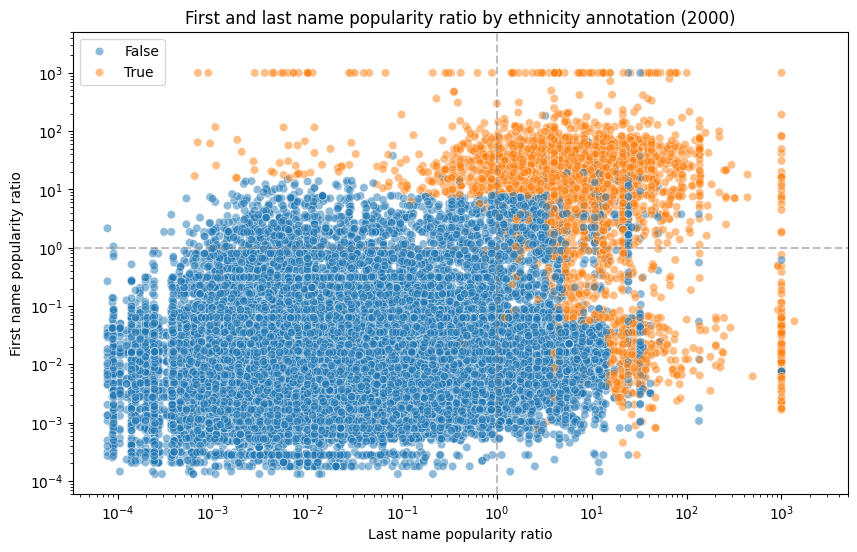

In [217]:
# scatter plot of firstname ratio against lastname ratio for each name
plt.figure(figsize=(10, 6))
sns.scatterplot(data=donors, x='lastname_ratio', y='firstname_ratio', hue='indian', alpha=0.5)
plt.title(f'First and last name popularity ratio by ethnicity annotation (20{year})')
plt.xlabel('Last name popularity ratio')
plt.ylabel('First name popularity ratio')

plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 5000)
plt.ylim(0, 5000)

plt.axhline(y=1, color='grey', alpha=0.5, linestyle='--')
plt.axvline(x=1, color='grey', alpha=0.5, linestyle='--')

plt.legend()
plt.show()